# Method Comparisons: IRASA

Comparing FOOOF to other related methods.

This notebook compares FOOOF to [IRASA](https://link.springer.com/content/pdf/10.1007/s10548-015-0448-0.pdf), 
the 'irregular-resampling auto-spectral analysis' method.

Note that IRASA and FOOOF are quite different, in part as FOOOF is primarily a model-fitting approach for both aperiodic and periodic activity, where as IRASA is primarily a decomposition technique for isolating aperiodic neural activity. Here we will focus on comparing them in terms of measuring aperiodic activity, as this is a context they can be directly compared on. 

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel

from neurodsp.spectral import compute_spectrum
from neurodsp.aperiodic import compute_irasa, fit_irasa
from neurodsp.utils import set_random_seed
from neurodsp.utils.download import load_ndsp_data
from neurodsp.sim import sim_synaptic_current, sim_combined

from fooof import FOOOF
from fooof.data import SimParams
from fooof.utils import trim_spectrum
from fooof.sim.params import param_sampler
from fooof.plts import plot_spectrum, plot_spectra

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from paths import FIGS_PATH
from plts import plot_errors_violin
from sims import gen_peak_def, gen_ap_def, gen_ap_knee_def
from utils import save_sim_data, load_sim_data
from analysis import cohens_d
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '08_comp-irasa/'

In [51]:
# Run settings
GEN_SIMS = True
SAVE_SIMS = True
SAVE_FIG = True
PLT_LOG = True

In [8]:
# Data settings
fit_range = (3, 150)
n_sims = 1000
ap_filt = (1, None)

In [53]:
# Convert exponent definitions for NeuroDSP format (uses negatives)
EXP_OPTS = [-val for val in EXP_OPTS]

# Power spectrum settings
psd_kwargs = {
    'nperseg' : FS,
    'noverlap' : 0.5 * FS
}

ylims = [-3.5, 0]

## Helper Functions

In [10]:
# Fixed fit function
from scipy.optimize import curve_fit
from neurodsp.aperiodic.irasa import fit_func
def fit_ap_ln(freqs, psd_ap):
    """Fit an aperiodic component with a linear function."""
    popt, _ = curve_fit(fit_func, np.log10(freqs), np.log10(psd_ap))
    return popt[0], popt[1]

# Knee fit function for IRASA
import warnings
from fooof.core.funcs import expo_function
def fit_ap_kn(freqs, psd_ap):
    """Fit an aperiodic component with a knee function."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, _ = curve_fit(expo_function, freqs, np.log10(psd_ap), p0=[0, 0, 0])
    return popt[0], popt[1], popt[2]

## Example Neural Signal

First, let's compare FOOOF and IRASA on an example neural signal.

In [11]:
# Load example data signal
sig = load_ndsp_data('sample_data_2.npy', folder='data')
data_fs = 1000

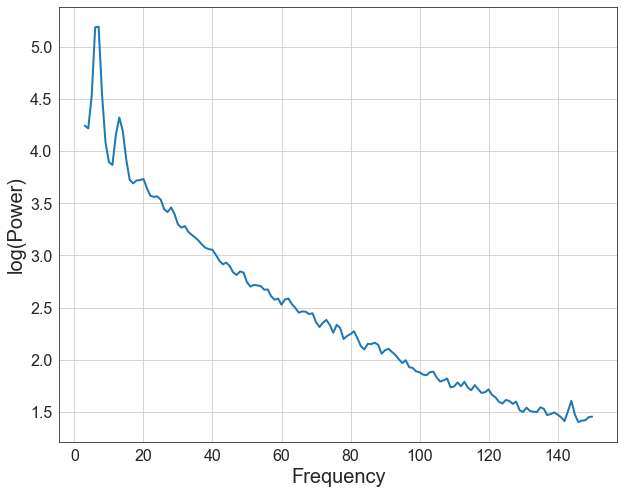

In [12]:
# Check power spectrum of example signal
freqs, powers = compute_spectrum(sig, data_fs)
freqs, powers = trim_spectrum(freqs, powers, fit_range)
plot_spectrum(freqs, powers, log_powers=True)

### FOOOF Fit

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.7115, 4129.5563, 2.8990                                     
                                                                                                  
                                       3 peaks were found:                                        
          

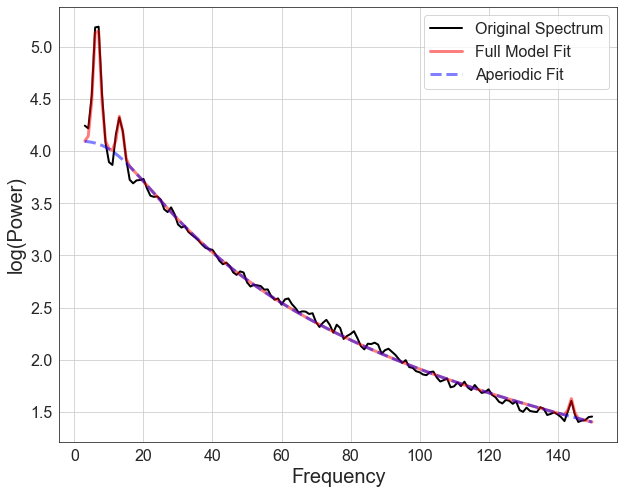

In [13]:
fm = FOOOF(min_peak_height=0.15, aperiodic_mode='knee', verbose=False)
fm.report(freqs, powers, fit_range)

### IRASA

In [14]:
# Compute IRASA, using default settings
ir_freqs_d1, psd_ap_d1, psd_pe_d1 = compute_irasa(sig, data_fs, f_range=fit_range)

# Compute IRASA, using custom (extra) resampling
hset = list(np.arange(0.5, 2.95, 0.05))
ir_freqs_d2, psd_ap_d2, psd_pe_d2 = compute_irasa(sig, data_fs, f_range=fit_range, hset=hset)

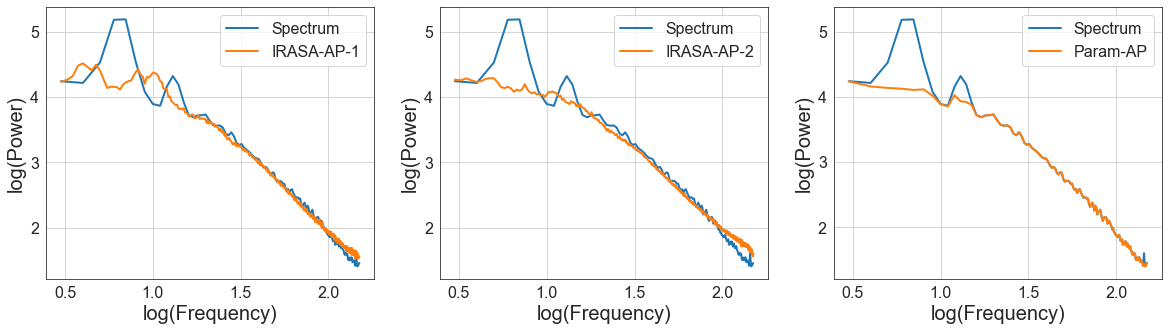

In [15]:
# Plot the comparisons across methods
_, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_spectra([fm.freqs, ir_freqs_d1], [np.power(10, fm.power_spectrum), psd_ap_d1],
             log_freqs=True, log_powers=True, ax=axes[0], labels=['Spectrum', 'IRASA-AP-1'])
plot_spectra([fm.freqs, ir_freqs_d2], [np.power(10, fm.power_spectrum), psd_ap_d2],
             log_freqs=True, log_powers=True, ax=axes[1], labels=['Spectrum', 'IRASA-AP-2'])
plot_spectra(fm.freqs, [fm.power_spectrum, fm._spectrum_peak_rm],
             log_freqs=True, log_powers=False, ax=axes[2], labels=['Spectrum', 'Param-AP'])
axes[2].set_ylabel('log(Power)');

In [16]:
# This cell saves the above plots, as individual figures
_, ax = plt.subplots(figsize=(8, 6))
plot_spectra([fm.freqs, ir_freqs_d1], [np.power(10, fm.power_spectrum), psd_ap_d1],
             log_freqs=True, log_powers=True, ax=ax, labels=['Spectrum', 'IRASA-AP-1'])
if SAVE_FIG: plt.savefig(pjoin(FIGS_PATH, FOLDER, 'data_irasa1.pdf'))
plt.close()

_, ax = plt.subplots(figsize=(8, 6))
plot_spectra([fm.freqs, ir_freqs_d2], [np.power(10, fm.power_spectrum), psd_ap_d2],
             log_freqs=True, log_powers=True, ax=axes[1], labels=['Spectrum', 'IRASA-AP-2'])
if SAVE_FIG: plt.savefig(pjoin(FIGS_PATH, FOLDER, 'data_irasa2.pdf'))
plt.close()

_, ax = plt.subplots(figsize=(8, 6))
plot_spectra(fm.freqs, [fm.power_spectrum, fm._spectrum_peak_rm],
             log_freqs=True, log_powers=False, ax=axes[2], labels=['Spectrum', 'Param-AP'])
axes[2].set_ylabel('log(Power)')
if SAVE_FIG: plt.savefig(pjoin(FIGS_PATH, FOLDER, 'data_param.pdf'))
plt.close()

### Compare Aperiodic Component Fits

In [17]:
# IRASA: Linear fit
ir_off, ir_exp = fit_ap_ln(ir_freqs_d1, psd_ap_d1)

# IRASA: Knee fit
ir_off_kn, ir_kn_kn, ir_exp_kn = fit_ap_kn(ir_freqs_d2, psd_ap_d2)

In [18]:
# Calculate the model fits of the IRASA fits
ir_ap_mod = fit_func(np.log10(fm.freqs), ir_off, ir_exp)
ir_ap_mod_kn = expo_function(fm.freqs, ir_off_kn, ir_kn_kn, ir_exp_kn)

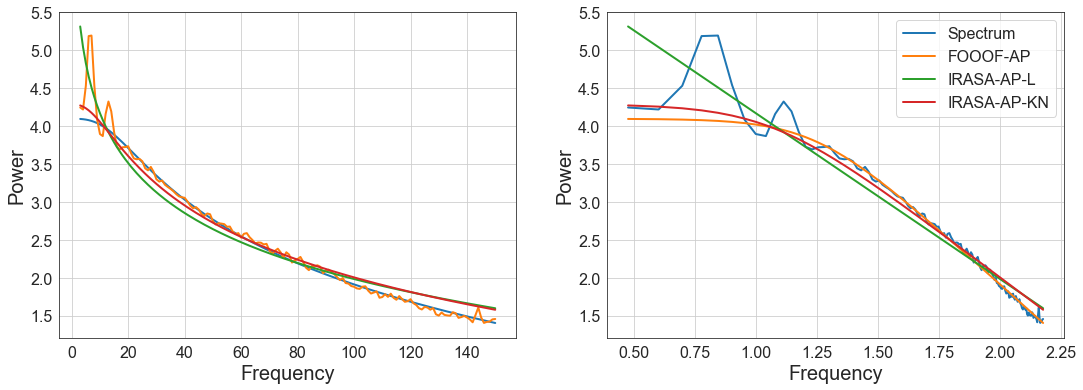

In [19]:
# Plot comparisons of aperiodic in both linear (left) and log (right)
_, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_spectra(fm.freqs, [fm._ap_fit, fm.power_spectrum, ir_ap_mod, ir_ap_mod_kn], ax=axes[0])
plot_spectra(np.log10(fm.freqs),
             [fm.power_spectrum, fm._ap_fit, ir_ap_mod, ir_ap_mod_kn],
             labels=['Spectrum', 'FOOOF-AP', 'IRASA-AP-L', 'IRASA-AP-KN'], ax=axes[1])

## Sims: One Peak

Run a series of simulations testing FOOOF vs. IRASA, with 1 peak on a low range (no knee).

In [20]:
data_name = 'comp_irasa_1p'

if GEN_SIMS:
    
    sigs = []
    sim_params = [None] * n_sims
    
    # Initialize generators to sample parameters from
    exp_sampler = param_sampler(EXP_OPTS, EXP_PROBS)
    cf_sampler = param_sampler(CF_OPTS, CF_PROBS)
    
    comp_vars = [1, 0.5]
    
    for ind in range(n_sims):
        
        exp_val = next(exp_sampler)
        cf_val = next(cf_sampler)
        sim_params[ind] = SimParams([None, exp_val], [cf_val, None, None], None)

        combs = {'sim_powerlaw' : {'exponent' : exp_val, 'f_range' : ap_filt},
                 'sim_oscillation' : {'freq' : cf_val}}

        sigs.append(sim_combined(N_SECONDS, FS, combs, comp_vars))
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, sigs, None, sim_params)

else:
    # Reload simulated data and parameter definitions
    sigs, _, sim_params = load_sim_data(data_name, FOLDER)

In [21]:
fm_errs_1p = []
ir_errs_1p = []

fm = FOOOF(*FOOOF_SETTINGS, verbose=False)

for sig, params in zip(sigs, sim_params):
    
    fm.fit(*compute_spectrum(sig, FS, **psd_kwargs), F_RANGE)
    fm_exp = fm.get_params('aperiodic_params', 'exponent')
    fm_errs_1p.append(-fm_exp - params.aperiodic_params[1])
    
    ir_freqs, psd_ap, psd_pe = compute_irasa(sig, FS, f_range=F_RANGE)
    ir_off, ir_exp = fit_irasa(ir_freqs, psd_ap)
    ir_errs_1p.append(ir_exp - params.aperiodic_params[1])

In [22]:
# Check the median error, to see if there is a directional bias
print('FOOOF - median error: {:1.4f}'.format(np.median(fm_errs_1p)))
print('IRASA - median error: {:1.4f}'.format(np.median(ir_errs_1p)))

FOOOF - median error: -0.0160
IRASA - median error: -0.0152


In [23]:
# Take absolute value of errors
fm_errs_1p = np.abs(fm_errs_1p)
ir_errs_1p = np.abs(ir_errs_1p)

In [24]:
# Collect errors together, for plotting
all_errs_1p = np.array([ir_errs_1p, fm_errs_1p])

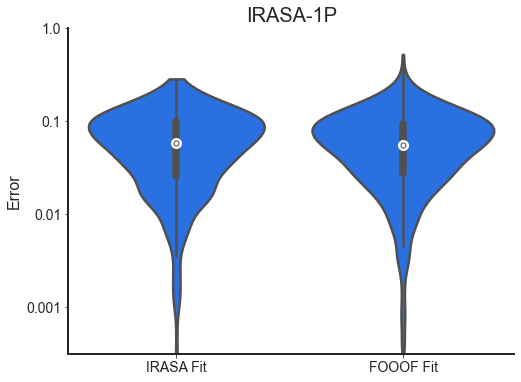

In [54]:
# Plot the error of the exponent reconstruction, comparing between methods
plot_errors_violin(all_errs_1p, 'IRASA-1P', x_axis=None, ylim=ylims,
                   x_ticks=['IRASA Fit', 'FOOOF Fit'], plt_log=PLT_LOG, 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'IRASA-1p'))

In [26]:
# Check mean and standard deviation of the errors
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(fm_errs_1p), np.std(fm_errs_1p)))
print('IRASA fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(ir_errs_1p), np.std(ir_errs_1p)))

FOOOF fits: 	 0.0663 	0.0525
IRASA fits: 	 0.0676 	0.0510


In [27]:
# Check t-test comparison
t_val_1p, p_val_1p = ttest_rel(ir_errs_1p, fm_errs_1p)
print('T-test: {:1.5f}, {}'.format(t_val_1p, p_val_1p))

T-test: 0.64095, 0.5216990628059464


In [28]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(ir_errs_1p, fm_errs_1p)))

Cohens-D: 0.0243


## Sims: Multi-Peak

Run a series of simulations testing FOOOF vs. IRASA, with multiple peaks on a low range (no knee).

In [29]:
data_name = 'comp_irasa_mp'

if GEN_SIMS:
    
    sigs = []
    sim_params = [None] * n_sims
    comp_vars = [1, 0.3, 0.3, 0.3]
    
    # Initialize generators to sample parameters from
    exp_sampler = param_sampler(EXP_OPTS, EXP_PROBS)
    cf_sampler = param_sampler(CF_OPTS, CF_PROBS)
    
    for ind in range(n_sims):
        
        # Get the current values to use for the exponent and peak frequency
        exp_val = next(exp_sampler)
        cf1 = next(cf_sampler)
        cf2 = next(cf_sampler)
        cf3 = next(cf_sampler)

        # Collect together simulated parameters
        sim_params[ind] = SimParams([None, exp_val],
                                    [[cf1, None, None], [cf2, None, None], [cf3, None, None]],
                                    None)

        combs = {'sim_powerlaw' : {'exponent' : exp_val, 'f_range' : ap_filt},
                 'sim_oscillation' : [{'freq' : cf1}, {'freq' : cf2}, {'freq' : cf3}]}

        sigs.append(sim_combined(N_SECONDS, FS, combs, comp_vars))
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, sigs, None, sim_params)
        
else:
    # Reload simulated data and parameter definitions
    sigs, _, sim_params = load_sim_data(data_name, FOLDER)

In [30]:
fm_exps_mp = []
ir_exps_mp = []
fm_errs_mp = []
ir_errs_mp = []

fm = FOOOF(*FOOOF_SETTINGS, verbose=False)

for sig, params in zip(sigs, sim_params):
    
    fm.fit(*compute_spectrum(sig, FS, **psd_kwargs), F_RANGE)
    fm_exp = fm.get_params('aperiodic_params', 'exponent')
    fm_exps_mp.append(fm_exp)
    fm_errs_mp.append(-fm_exp - params.aperiodic_params[1])
    
    ir_freqs, psd_ap, psd_pe = compute_irasa(sig, FS, f_range=F_RANGE)
    ir_off, ir_exp = fit_irasa(ir_freqs, psd_ap)
    fm_exps_mp.append(ir_exp)
    ir_errs_mp.append(ir_exp - params.aperiodic_params[1])

In [31]:
# Check the median error, to see if there is a directional bias
print('FOOOF - median error: {:1.4f}'.format(np.median(fm_errs_mp)))
print('IRASA - median error: {:1.4f}'.format(np.median(ir_errs_mp)))

FOOOF - median error: -0.0055
IRASA - median error: -0.0420


In [32]:
# Take absolute value of errors
fm_errs_mp = np.abs(fm_errs_mp)
ir_errs_mp = np.abs(ir_errs_mp)

In [33]:
# Collect errors together, for plotting
all_errs_mp = np.array([ir_errs_mp, fm_errs_mp])

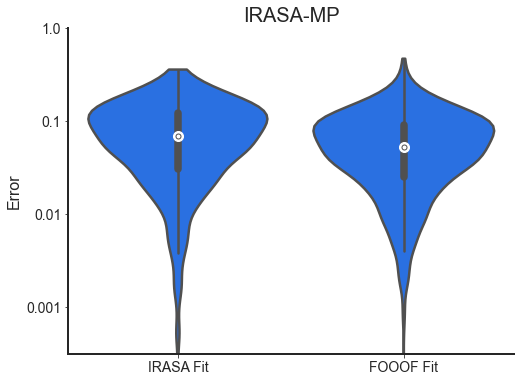

In [55]:
# Plot the error of the exponent reconstruction, comparing between methods
plot_errors_violin(all_errs_mp, 'IRASA-MP', x_axis=None, ylim=ylims,
                   x_ticks=['IRASA Fit', 'FOOOF Fit'], plt_log=PLT_LOG, 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'IRASA-mp'))

In [35]:
# Check mean and standard deviation of the errors
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(fm_errs_mp), np.std(fm_errs_mp)))
print('IRASA fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(ir_errs_mp), np.std(ir_errs_mp)))

FOOOF fits: 	 0.0649 	0.0546
IRASA fits: 	 0.0825 	0.0647


In [36]:
# Check t-test comparison
t_val_mp, p_val_mp = ttest_rel(ir_errs_mp, fm_errs_mp)
print('T-test: {:1.5f}, {}'.format(t_val_mp, p_val_mp))

T-test: 7.45114, 2.000097615107247e-13


In [37]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(ir_errs_mp, fm_errs_mp)))

Cohens-D: 0.2941


## Knee

Run a series of simulations testing FOOOF vs. IRASA, with one peak across a broad range, with a knee.

In [38]:
exp_val = -2

if GEN_SIMS:
    
    sigs = []
    comp_vars = [1, 0.5]
    
    # Initialize generators to sample parameters from
    cf_sampler = param_sampler(CF_OPTS, CF_PROBS)
    
    for ind in range(n_sims):
        
        cf_val = next(cf_sampler)
    
        combs = {'sim_synaptic_current' : {},
                 'sim_oscillation' : {'freq' : cf_val}}
    
        sigs.append(sim_combined(N_SECONDS, FS, combs, comp_vars))

In [39]:
fm_errs_kn = []
ir_errs_kn = []
ir_errs_li = []

fm_exps_kn = []
ir_exps_kn = []

F_RANGE_LONG = [1, 150]

fm = FOOOF(*FOOOF_SETTINGS_KNEE, verbose=False)
 
for sig in sigs:    
    
    fm.fit(*compute_spectrum(sig, FS, **psd_kwargs), F_RANGE_LONG)
    fm_exp = fm.get_params('aperiodic_params', 'exponent')
    fm_errs_kn.append(-fm_exp - exp_val)
    
    ir_freqs, psd_ap, psd_pe = compute_irasa(sig, FS, f_range=F_RANGE_LONG)
    
    # IRASA - Knee fit
    ir_off_kn, ir_kn_kn, ir_exp_kn = fit_ap_kn(ir_freqs, psd_ap)
    ir_errs_kn.append(-ir_exp_kn - exp_val)

    # IRASA - Linear fit
    ir_off, ir_exp_l = fit_ap_ln(ir_freqs, psd_ap)
    ir_errs_li.append(ir_exp_l - exp_val)
    
    # Collect the actual exponent values
    fm_exps_kn.append(fm_exp)
    ir_exps_kn.append(ir_exp_kn)

In [40]:
# Check the median error, to see if there is a directional bias
print('FOOOF - median error: {:1.4f}'.format(np.median(fm_errs_kn)))
print('IRASA - median error: {:1.4f}'.format(np.median(ir_errs_kn)))

FOOOF - median error: 0.0906
IRASA - median error: 0.1592


In [41]:
# Take absolute value of errors
fm_errs_kn = np.abs(fm_errs_kn)
ir_errs_kn = np.abs(ir_errs_kn)

In [42]:
# Collect errors together, for plotting
all_errs_kn = np.array([ir_errs_kn, fm_errs_kn])

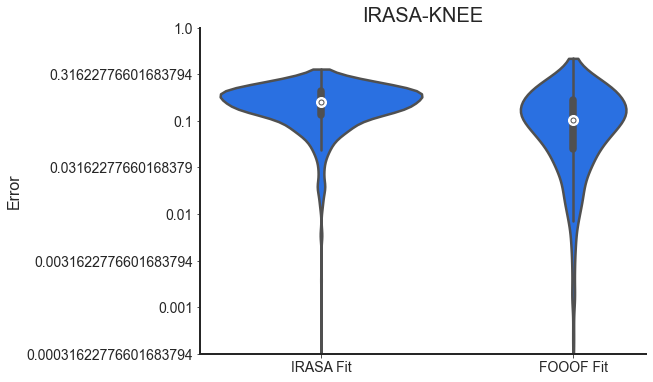

In [56]:
# Plot the error of the exponent reconstruction, comparing between methods
plot_errors_violin(all_errs_kn, 'IRASA-KNEE', x_axis=None, ylim=ylims,
                   x_ticks=['IRASA Fit', 'FOOOF Fit'], plt_log=PLT_LOG, 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'IRASA-kn'))

In [44]:
YLIMS_AP = [-3.25, 0]

In [45]:
# Check mean and standard deviation of the errors
print('FOOOF fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(fm_errs_kn), np.std(fm_errs_kn)))
print('IRASA fits: \t {:1.4f} \t{:1.4f}'.format(\
    np.mean(ir_errs_kn), np.std(ir_errs_kn)))

FOOOF fits: 	 0.1171 	0.0851
IRASA fits: 	 0.1597 	0.0663


In [46]:
# Check the linear fit with IRASA using a linear fit
print('Median Error - LinearIRASA: {:1.4f}'.format(np.median(ir_errs_li)))

Median Error - LinearIRASA: 0.7122


In [47]:
# Check t-test comparison
t_val_kn, p_val_kn = ttest_rel(ir_errs_kn, fm_errs_kn)
print('T-test: {:1.5f}, {}'.format(t_val_kn, p_val_kn))

T-test: 15.13237, 9.89129553712556e-47


In [48]:
# Check cohens-d effect size
print('Cohens-D: {:1.4f}'.format(cohens_d(ir_errs_kn, fm_errs_kn)))

Cohens-D: 0.5587


In [49]:
print('Median FOOOF exp: {:1.4f}'.format(np.median(fm_exps_kn)))
print('Median IRASA exp: {:1.4f}'.format(np.median(ir_exps_kn)))

Median FOOOF exp: 1.9094
Median IRASA exp: 1.8408


In [50]:
print('T-test FOOOF vs. true value: ', *ttest_1samp(fm_exps_kn, 2))
print('T-test IRASA vs. true value: ', *ttest_1samp(ir_exps_kn, 2))

T-test FOOOF vs. true value:  -25.228006869411548 4.754902052802013e-109
T-test IRASA vs. true value:  -73.90005237715624 0.0
